In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit, logit

## Load data

In [5]:
df = pd.read_csv("simulated_collab_survey_1000_randomized.csv")
df

,role,experience,experience_code,peopleparticipation,peopleparticipation_code,dashboarduse,aiuse,understanding,access,equity,traceability,effectiveness
0,Project manager,0-1,0,2-3,0,1,1,3,2,2,3,0
1,Developer,2-4,1,4-6,1,1,0,2,1,2,2,1
2,Developer,8+,3,4-6,1,1,1,2,4,2,2,1
3,Other,2-4,1,4-6,1,1,1,2,3,2,4,1
4,Developer,8+,3,2-3,0,1,0,1,3,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Developer,2-4,1,2-3,0,0,0,1,3,3,2,1
996,Analyst,2-4,1,2-3,0,1,0,3,3,3,3,1
997,Developer,2-4,1,2-3,0,1,1,2,4,2,2,1
998,Project manager,8+,3,4-6,1,1,0,2,2,2,2,1


## First approach


=== Mediation snapshot (randomized world) ===
Total indirect (Dash): 0.013
Total indirect (AI):   0.2668
Direct (Dash):         0.1171
Direct (AI):           -0.1291

Logit summary:
                                Results: Logit
Model:                  Logit                Method:               MLE       
Dependent Variable:     effectiveness        Pseudo R-squared:     0.084     
Date:                   2025-09-18 20:10     AIC:                  1286.9227 
No. Observations:       1000                 BIC:                  1350.7235 
Df Model:               12                   Log-Likelihood:       -630.46   
Df Residuals:           987                  LL-Null:              -688.14   
Converged:              1.0000               LLR p-value:          5.1937e-19
No. Iterations:         5.0000               Scale:                1.0000    
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

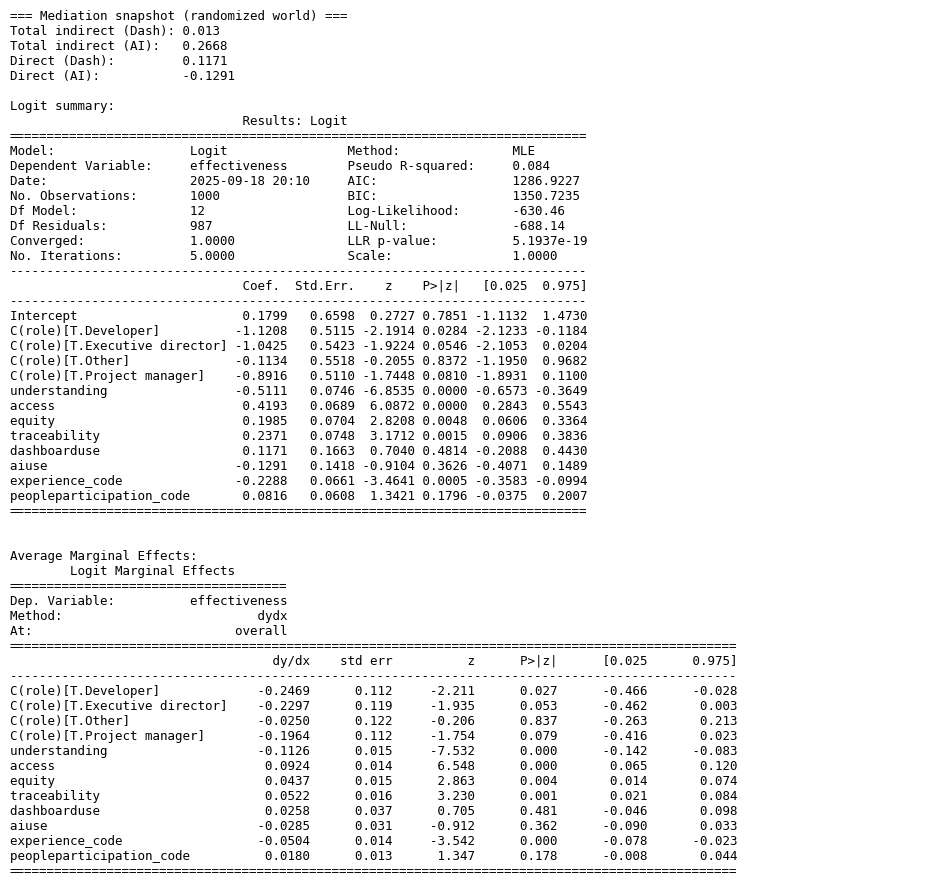

In [6]:

# First-stage OLS for mediators
m_understanding = smf.ols("understanding ~ dashboarduse + aiuse + C(role) + experience_code + peopleparticipation_code", data=df).fit()
m_access        = smf.ols("access        ~ dashboarduse + aiuse + C(role) + experience_code + peopleparticipation_code", data=df).fit()
m_equity        = smf.ols("equity        ~ dashboarduse + aiuse + C(role) + experience_code + peopleparticipation_code", data=df).fit()
m_traceability  = smf.ols("traceability  ~ dashboarduse + aiuse + C(role) + experience_code + peopleparticipation_code", data=df).fit()

# Outcome-stage logit
form_y = "effectiveness ~ understanding + access + equity + traceability + dashboarduse + aiuse + C(role) + experience_code + peopleparticipation_code"
m_y = smf.logit(form_y, data=df).fit(disp=False)
marg = m_y.get_margeff(at="overall")

df["predicted_understanding"] = m_understanding.predict(df)
df["predicted_access"] = m_access.predict(df)
df["predicted_equity"] = m_equity.predict(df)
df["predicted_traceability"] = m_traceability.predict(df)
df["predicted_effectiveness"] = m_y.predict(df)

# Simple product-of-coefs diagnostic (log-odds scale)
a_dash = {
    "understanding": m_understanding.params.get("dashboarduse", 0.0),
    "access":        m_access.params.get("dashboarduse", 0.0),
    "equity":        m_equity.params.get("dashboarduse", 0.0),
    "traceability":  m_traceability.params.get("dashboarduse", 0.0),
}
a_ai = {
    "understanding": m_understanding.params.get("aiuse", 0.0),
    "access":        m_access.params.get("aiuse", 0.0),
    "equity":        m_equity.params.get("aiuse", 0.0),
    "traceability":  m_traceability.params.get("aiuse", 0.0),
}
b = {
    "understanding": m_y.params.get("understanding", 0.0),
    "access":        m_y.params.get("access", 0.0),
    "equity":        m_y.params.get("equity", 0.0),
    "traceability":  m_y.params.get("traceability", 0.0),
}
indirect_dash = sum(a_dash[k]*b[k] for k in b)
indirect_ai   = sum(a_ai[k]*b[k] for k in b)

print("\n=== Mediation snapshot (randomized world) ===")
print("Total indirect (Dash):", round(indirect_dash, 4))
print("Total indirect (AI):  ", round(indirect_ai, 4))
print("Direct (Dash):        ", round(m_y.params.get('dashboarduse', 0.0), 4))
print("Direct (AI):          ", round(m_y.params.get('aiuse', 0.0), 4))
print("\nLogit summary:\n", m_y.summary2().as_text())
print("\nAverage Marginal Effects:\n", marg.summary().as_text())

#####################################################
import matplotlib.pyplot as plt

# Collect the results as one text string
results_text = []
results_text.append("=== Mediation snapshot (randomized world) ===")
results_text.append(f"Total indirect (Dash): {round(indirect_dash, 4)}")
results_text.append(f"Total indirect (AI):   {round(indirect_ai, 4)}")
results_text.append(f"Direct (Dash):         {round(m_y.params.get('dashboarduse', 0.0), 4)}")
results_text.append(f"Direct (AI):           {round(m_y.params.get('aiuse', 0.0), 4)}")
results_text.append("\nLogit summary:\n" + m_y.summary2().as_text())
results_text.append("\nAverage Marginal Effects:\n" + marg.summary().as_text())

# Join into one big string
final_text = "\n".join(results_text)

# Create figure and render the text
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis("off")
ax.text(0, 1, final_text, fontsize=9, va="top", family="monospace")

plt.savefig("mediation_results.png", bbox_inches="tight", dpi=300)

from google.colab import files
files.download("mediation_results.png")


/tmp/ipython-input-2340181462.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[actual], y=df[pred], ax=ax, palette="Set3")
/tmp/ipython-input-2340181462.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[actual], y=df[pred], ax=ax, palette="Set3")
/tmp/ipython-input-2340181462.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[actual], y=df[pred], ax=ax, palette="Set3")
/tmp/ipython-input-2340181462.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign th

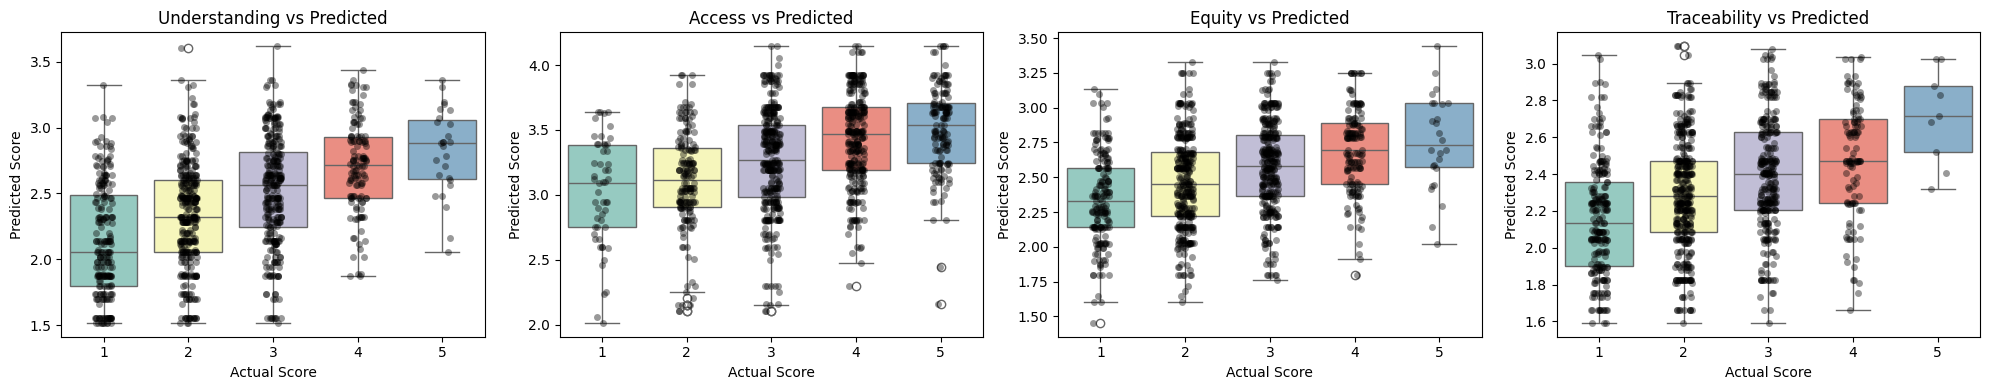

/tmp/ipython-input-2340181462.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["effectiveness"], y=df["predicted_effectiveness"], palette="Set2")


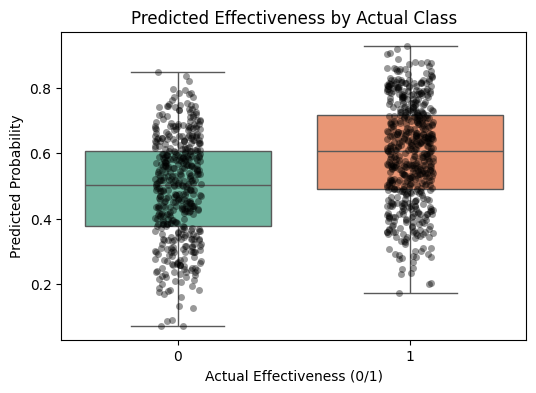

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of discrete score variables
score_vars = [
    ("understanding", "predicted_understanding"),
    ("access", "predicted_access"),
    ("equity", "predicted_equity"),
    ("traceability", "predicted_traceability")
]

# Plot for discrete scores
fig, axes = plt.subplots(1, len(score_vars), figsize=(20, 4))

for i, (actual, pred) in enumerate(score_vars):
    ax = axes[i]
    sns.boxplot(x=df[actual], y=df[pred], ax=ax, palette="Set3")
    sns.stripplot(x=df[actual], y=df[pred], ax=ax, color="black", alpha=0.4, jitter=True)
    ax.set_title(f"{actual.capitalize()} vs Predicted")
    ax.set_xlabel("Actual Score")
    ax.set_ylabel("Predicted Score")

plt.tight_layout()
plt.show()

# For binary effectiveness
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["effectiveness"], y=df["predicted_effectiveness"], palette="Set2")
sns.stripplot(x=df["effectiveness"], y=df["predicted_effectiveness"],
              color="black", alpha=0.4, jitter=True)
plt.title("Predicted Effectiveness by Actual Class")
plt.xlabel("Actual Effectiveness (0/1)")
plt.ylabel("Predicted Probability")
plt.show()


## Second approach

In [8]:
# ==== First-stage table
import pandas as pd

mods_raw = {
    "Understanding": m_understanding,
    "Access":        m_access,
    "Equity":        m_equity,
    "Traceability":  m_traceability,
}
# robust (HC3) versions
mods = {k: v.get_robustcov_results(cov_type="HC3") for k, v in mods_raw.items()}

rows = [
    ("Dashboard use", "dashboarduse"),
    ("AI use",        "aiuse"),
    ("Experience",    "experience_code"),
    ("Group size",    "peopleparticipation_code"),
]

def stars(p):
    return "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.10 else ""

def fmt(col_name, term):
    m = mods[col_name]
    names = mods_raw[col_name].model.exog_names
    if term not in names:
        return ""
    j = names.index(term)
    coef = float(m.params[j])
    se   = float(m.bse[j])
    p    = float(m.pvalues[j])
    return f"{coef:.3f} ({se:.3f}){stars(p)}"

first_stage = pd.DataFrame(
    {col: [fmt(col, term) for _, term in rows] for col in mods},
    index=[name for name, _ in rows]
)

# Add R^2 and N
fit_rows = pd.DataFrame(
    {col: [mods_raw[col].rsquared, int(mods_raw[col].nobs)] for col in mods_raw},
    index=["R^2", "N"]
)

first_stage = pd.concat([first_stage, fit_rows])

print("\n=== First-stage regressions with sig stars) ===")
print(first_stage)






=== First-stage regressions with sig stars) ===
                   Understanding             Access             Equity  \
Dashboard use  -0.241 (0.073)***  -0.220 (0.076)***    0.151 (0.073)**   
AI use         -0.180 (0.062)***   0.443 (0.066)***  -0.247 (0.063)***   
Experience     -0.293 (0.026)***   0.144 (0.027)***  -0.212 (0.025)***   
Group size      0.142 (0.028)***     -0.047 (0.029)  -0.114 (0.027)***   
R^2                      0.18105           0.135692           0.113019   
N                         1000.0             1000.0             1000.0   

                    Traceability  
Dashboard use  -0.202 (0.072)***  
AI use          0.160 (0.059)***  
Experience     -0.192 (0.025)***  
Group size      0.072 (0.025)***  
R^2                     0.111899  
N                         1000.0  


                            OLS Regression Results                            
Dep. Variable:                eff_lin   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     20.83
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           2.29e-29
Time:                        20:14:11   Log-Likelihood:                -3931.4
No. Observations:                1000   AIC:                             7881.
Df Residuals:                     991   BIC:                             7925.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

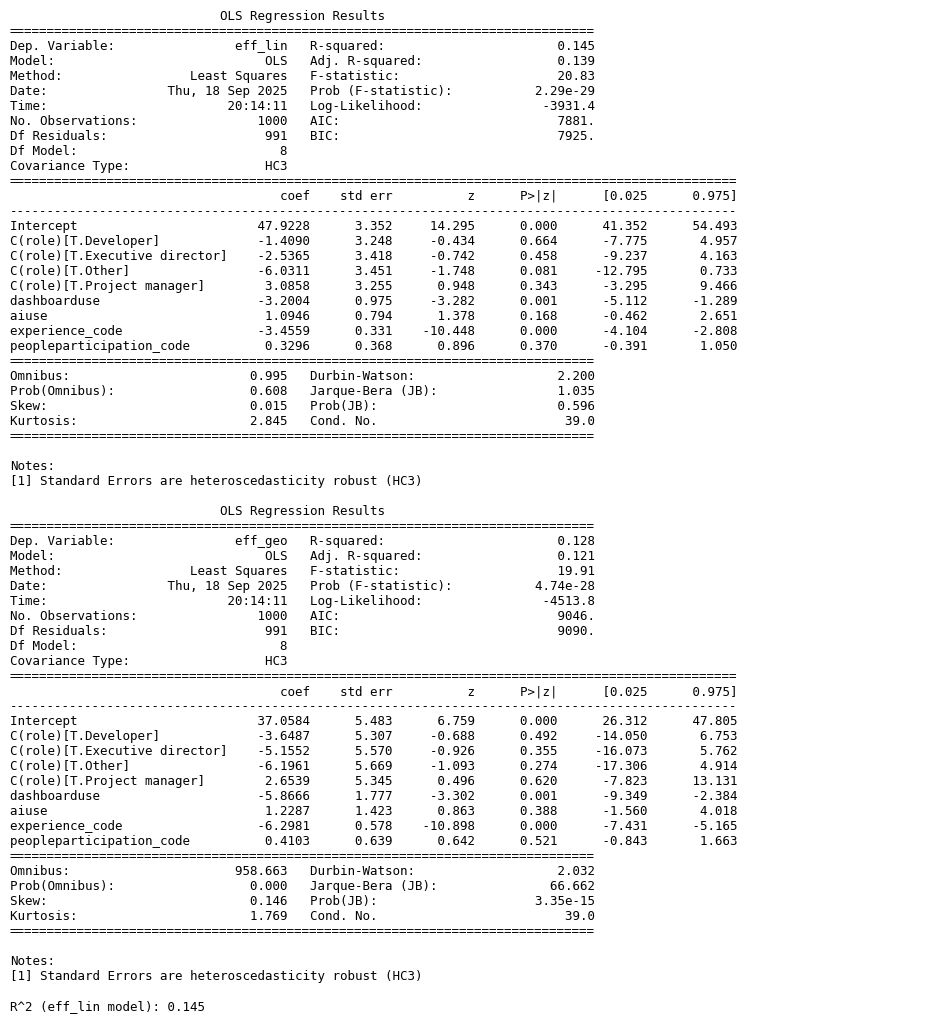

In [9]:
# Second stage

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# 1) Build deterministic effectiveness from mediators
mediators = ["understanding", "access", "equity", "traceability"]

# Normalize Likert 1..5 -> 0..1
for m in mediators:
    if df[m].min() < 1 or df[m].max() > 5:
        raise ValueError(f"{m} must be on 1..5 Likert.")
df_norm = df[mediators].apply(lambda s: (s - 1) / 4.0)

# Equal-weight linear index scaled to 0-100
df["eff_lin"] = 100.0 * df_norm.mean(axis=1)

# geometric-mean index (also 0-100)
eps = 1e-12
df["eff_geo"] = 100.0 * (df_norm.add(eps)).prod(axis=1) ** (1.0 / len(mediators))



# 2 Regress computed effectiveness on tools + controls
#  linear index:
formula = (
    "eff_lin ~ dashboarduse + aiuse + C(role)"
    " + experience_code + peopleparticipation_code"
)

ols = smf.ols(formula, data=df).fit(cov_type="HC3")  # robust SEs
print(ols.summary())
df["predicted_effectiveness_lin"] = ols.predict(df)

#  geometric index:
ols_geo = smf.ols("eff_geo ~ dashboarduse + aiuse + C(role) + experience_code + peopleparticipation_code",
                  data=df).fit(cov_type="HC3")
df["predicted_effectiveness_geo"] = ols_geo.predict(df)
print(ols_geo.summary())


coef_table = ols.summary2().tables[1]
r2 = ols.rsquared
print("\nR^2 (eff_lin model):", round(r2, 3))

############################################3
import matplotlib.pyplot as plt

# Collect results as text
results_text = ols.summary().as_text() + "\n\n" + ols_geo.summary().as_text()
results_text += f"\n\nR^2 (eff_lin model): {round(r2, 3)}"

# Render text into figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis("off")
ax.text(0, 1, results_text, fontsize=9, va="top", family="monospace")

plt.savefig("second_approach_results.png", bbox_inches="tight", dpi=300)

from google.colab import files
files.download("second_approach_results.png")



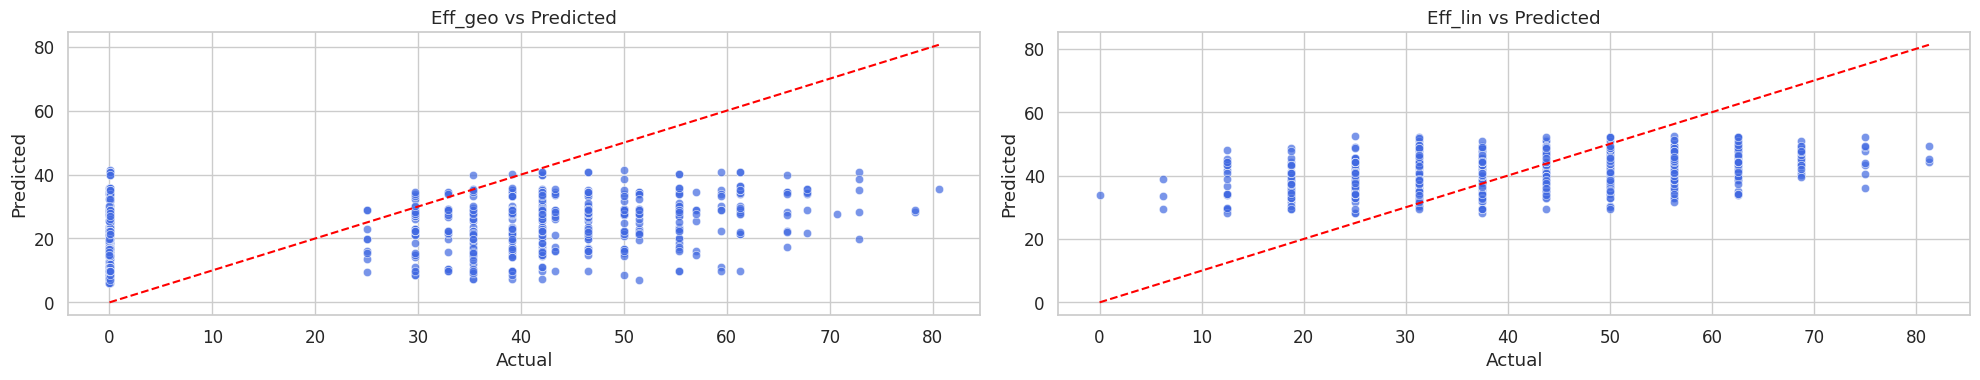

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example: load your dataframe
# df = pd.read_csv("your_file.csv")  # or read from Stata/Excel depending on your data

# List of actual vs predicted variable pairs
pairs = [
    ("eff_geo", "predicted_effectiveness_geo"),
    ("eff_lin", "predicted_effectiveness_lin")
]

# Set style
sns.set(style="whitegrid", font_scale=1.1)

# Plot
fig, axes = plt.subplots(1, len(pairs), figsize=(20, 4))

for i, (actual, pred) in enumerate(pairs):
    ax = axes[i]
    sns.scatterplot(x=df[actual], y=df[pred], ax=ax, alpha=0.7, color="royalblue")
    ax.plot([df[actual].min(), df[actual].max()],
            [df[actual].min(), df[actual].max()],
            color="red", linestyle="--")  # 45° line
    ax.set_title(f"{actual.capitalize()} vs Predicted")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()
